### Import necessary libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import os
import zipfile
import nltk
from nltk.tokenize import word_tokenize

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        if 'train' in path:
            train_path = path
        elif 'test' in path:
            test_path = path

print("train:", train_path)
print("test:", test_path)

train: /kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
test: /kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


In [3]:
train_df = pd.read_table(train_path)
test_df = pd.read_table(test_path)

train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66291 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


There is a null value in test_df.Phrase that we have to replace

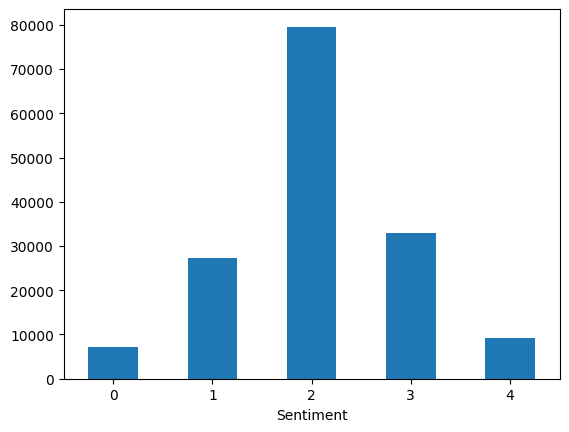

In [4]:
import matplotlib.pyplot as plt
train_df.Sentiment.value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

The most common sentiment is 2 which is neutral

In [5]:

test_df['Phrase'] = test_df['Phrase'].fillna('')

In [6]:



# train_df = process_text(__train_dataset)
# test_dataset = process_text(__test_dataset)

In [7]:
import re
import string
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

stemmer = SnowballStemmer('english')
english_stopwords = stopwords.words('english')

# print("Before:\n", train_df.Phrase[10:20])
train_df['Phrase'] = [re.sub(r'\d+', 'num', re.sub(r"[^\s\w]", "", t)).lower() for t in train_df.Phrase]
test_df['Phrase'] =  [re.sub(r'\d+', 'num', re.sub(r"[^\s\w]", "", t)).lower() for t in test_df.Phrase]

# print("After:\n", train_df.Phrase[10:20])
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer =lambda text:[stemmer.stem(token) for token in word_tokenize(text) if token not in english_stopwords[:115]],
                            stop_words=english_stopwords[:115],
                            ngram_range=(1,2),
                            max_features=2000)


In [8]:
vectorizer.fit(train_df.Phrase)
vectorizer.get_feature_names_out()[:150]

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'll', 're', 've'] not in stop_words.
  warnings.warn(


array(['abandon', 'abil', 'abl', 'absolut', 'absorb', 'abstract',
       'absurd', 'accent', 'accept', 'access', 'accomplish', 'accur',
       'ach', 'achiev', 'across', 'act', 'action', 'action film',
       'action movi', 'action sequenc', 'actor', 'actress', 'actual',
       'ad', 'adam', 'adam sandler', 'adapt', 'add', 'addit', 'admir',
       'admit', 'adolesc', 'adult', 'adventur', 'affair', 'affect',
       'afraid', 'afterschool', 'age', 'ago', 'ahead', 'aim', 'aimless',
       'air', 'alien', 'aliv', 'allen', 'allow', 'almost', 'alon',
       'along', 'alreadi', 'also', 'altern', 'although', 'alway',
       'amateurish', 'amaz', 'ambigu', 'ambit', 'ambiti', 'america',
       'american', 'among', 'amount', 'amus', 'analyz', 'angel', 'angst',
       'anim', 'annoy', 'anoth', 'answer', 'anyon', 'anyth', 'apart',
       'appar', 'appeal', 'appear', 'appreci', 'approach', 'appropri',
       'area', 'argu', 'argument', 'around', 'arriv', 'art', 'artifici',
       'artist', 'ask', 'a

In [9]:
from sklearn.model_selection import train_test_split

X = vectorizer.transform(train_df.Phrase)
y = train_df.Sentiment
X_test = vectorizer.transform(test_df.Phrase)


X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred1 = model.predict(X_val)

accuracy_score(y_val, y_pred1)

0.6319043957452262

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=2000)

grid = {'penalty':['l1', 'l2'],
       'C':[0.001, 0.01, 0.1, 1],
       'solver':['liblinear','lbfgs']}
grid_search = GridSearchCV(log_reg, grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)
y_pred2 = grid_search.best_estimator_.predict(X_val)

accuracy_score(y_val, y_pred2)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

0.6136101499423299

In [12]:
# from sklearn.naive_bayes import GaussianNB
# nb = GaussianNB()
# nb.fit(X_train, y_train)

# y_pred3 = nb.predict(X_val)
# accuracy_score(y_val, y_pred3)

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=2000)

grid = {'penalty':['l1', 'l2'],
       'C':[0.001, 0.01, 0.1, 1],
       'solver':['liblinear','lbfgs']}
grid_search = GridSearchCV(log_reg, grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X, y)
y_pred2 = grid_search.best_estimator_.predict(X_val)

test_pred = grid_search.best_estimator_.predict(X_test)
accuracy_score(y_val, y_pred2)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

0.6290849673202614

In [14]:
submission_df = pd.read_csv("/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv")
submission_df.Sentiment = test_pred
submission_df.to_csv('submission.csv', index=None)